# Overview
This notebook will walk you through how to use trained GPs. 


In [23]:
import pickle
from pathlib import Path
from pprint import pp

import numpy as np

from holodeck.gps import gp_utils
import sys
sys.modules['gp_utils'] = gp_utils
from holodeck.gps import gp_utils as gu
import h5py
import holodeck as holo
import matplotlib.pyplot as plt
from holodeck.gps import plotting_utils as pu
from holodeck.gps import sam_utils as su
from holodeck.gps.gp_utils import GaussProc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First, we need to read in the library

In [2]:
spectra_file = Path(
    "/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/spec_libraries/broad-uniform-02b_4k/sam_lib.hdf5"
)


spectra = h5py.File(spectra_file, "r")

### Loading the trained GPs
We'll load in the .PKL of trained GPs. Note that the `gaussproc` class was renamed to `GaussProc` to follow camel case standards for class names.

The GPs should be named programmatically based on the library's name, so we'll use that.

In [3]:
gaussproc = GaussProc  # For backwards compatibility before change to camel-case

gp_file = "trained_gp_" + spectra_file.parent.name + ".pkl"
#gp_file = 'trained_gp_broad-uniform-02b_4k_20230328_003846_new.pkl'
gp_file = 'trained_gp_broad-uniform-02b_4k_14f_20230404_091047.pkl'
with open(spectra_file.parent / gp_file, "rb") as f:
    gp_george = pickle.load(f)

### Setting up GP predictions
Here we prepare the GPs for predictions.
It's possible that the older models have byte strings instead of strings as their dictionary keys. If so, copy the below code and run it immediately after this cell.
```python
for gp in gp_george:
    gp.par_dict = { key.decode('ascii'): gp.par_dict.get(key) for key in gp.par_dict.keys() }
```

In [4]:
print(gu)
print(gp_utils)
print(gp_utils is gu)

<module 'holodeck.gps.gp_utils' from '/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/gps/gp_utils.py'>
<module 'holodeck.gps.gp_utils' from '/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/gps/gp_utils.py'>
True


In [5]:
gp = gu.set_up_predictions(spectra, gp_george)

### Choosing what to hold constant
In the following cell, a `mean_pars` dictionary is created. This contains the mean value of the parameter over its allowed range. This values in this dictionary tell the plotting routines what constant values to use. Feel free to construct your own with different values. Each `gp_george` has a `gp_george.par_dict` that contains each parameter and its allowed range. 

Another example constant dictionary you could create is one of the minimum values
```python
min_pars = {key:gp_george[0].par_dict[key]['min'] for key in gp_george[0].par_dict.keys()}
```

In [6]:
mean_pars = gu.mean_par_dict(gp_george)

pp(mean_pars)

{'hard_time': 5.1005913911261445,
 'gsmf_phi0': -2.4999859769674853,
 'gsmf_mchar0_log10': 11.250130154053368,
 'mmb_amp_log10': 8.500068587816639,
 'mmb_scatter': 0.2999915647027355}


In [7]:
pp(gp_george[0].par_dict)

{'hard_time': {'min': 0.20128777239545917, 'max': 9.99989500985683},
 'gsmf_phi0': {'min': -3.499955498880869, 'max': -1.5000164550541013},
 'gsmf_mchar0_log10': {'min': 10.500352536142504, 'max': 11.999907771964232},
 'mmb_amp_log10': {'min': 7.500221490570565, 'max': 9.49991568506271},
 'mmb_scatter': {'min': 8.458556027927042e-05, 'max': 0.5998985438451918}}


### Plotting individual parameters
The following cell will plot GWBs while varying the parameter of interest with other parameters held constant. You may choose whether to calculate smoothed-mean GWBs from a SAM to overlay. The avaiable SAM configurations are in `sam_utils.py`



In [8]:
sam_model = su.Broad_Uniform_02B()
#sam_model = holo.param_spaces.PS_Broad_Uniform_02B

In [9]:
#sam_model.params()
#sam_model.names

In [10]:
pars_linspace = gu.pars_linspace_dict(gp_george, num_points=5)
print(list(pars_linspace.keys()))

['hard_time', 'gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_amp_log10', 'mmb_scatter']


In [11]:
print("this is for github token testing purposes")

this is for github token testing purposes


21:29:28 INFO : calculating normalization exactly [hardening.py:__init__]
21:29:59 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
21:29:59 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
21:29:59 INFO : Adding MMbulge scatter (2.0000e-02) [sam.py:static_binary_density]
21:29:59 INFO : 	dens bef: (1.81e-43, 7.15e-20, 1.25e-08, 8.80e-04, 2.27e-02, 9.15e-02, 4.85e-01) [sam.py:static_binary_density]
21:30:05 INFO : Scatter added after 5.962948 sec [sam.py:static_binary_density]
21:30:05 INFO : 	dens aft: (1.02e-27, 3.50e-11, 2.14e-08, 8.90e-04, 2.28e-02, 9.23e-02, 4.60e-01) [sam.py:static_binary_density]
21:30:05 INFO : 	mass: 3.83e-01 ==> 3.84e-01 || change = 1.1828e-03 [sam.py:static_binary_density]
21:30:05 WARNING : NOT zeroing out systems with GMTs extending past redshift zero! [sam.py:static_binary_density]
21:30:06 INFO : fraction of coalesced binaries: 9.55e+04/2.56e+06 = 3.73e-02 [sam.py:dynamic_binary

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


21:30:09 INFO : fraction of stalled binary-xvals: 2.18e+06/2.56e+06 = 8.52e-01 [sam.py:dynamic_binary_number]
21:30:09 INFO : fraction of binaries stalled at all xvals: 5.51e+04/6.40e+04 = 8.61e-01 [sam.py:dynamic_binary_number]
21:30:09 WARNING : A large fraction of binaries are stalled at all xvals!  8.6092e-01 [sam.py:dynamic_binary_number]
(40, 1000)


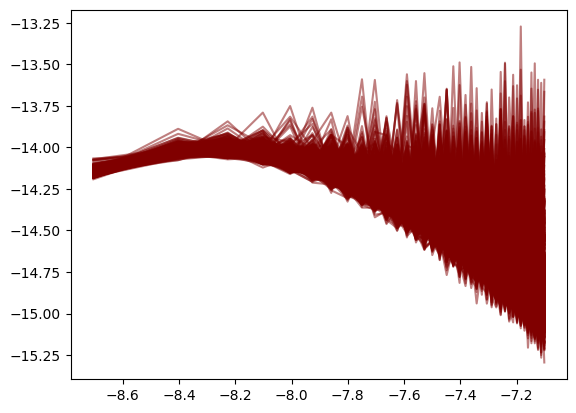

In [27]:
nreal = 1000
fig, axs = plt.subplots(1,1)
env_pars = {'hard_time':4.18, 'gsmf_phi0':-1.57, 'gsmf_mchar0_log10':11.29, 'mmb_amp_log10':8.87, 'mmb_scatter':0.02}
fobs_edges = spectra["fobs_edges"][:]
fobs = spectra["fobs"][:]
sam, hard = sam_model.sam_for_params(env_pars, sam_shape=40)
gwb = sam.gwb(fobs_edges, realize=nreal, hard=hard)
data = dict(fobs=fobs, fobs_edges=fobs_edges, gwb=gwb)
meta_data = dict(pnum=None, pdim=5, nsamples=1, librarian_version='0.1.0', param_names=['hard_time', 'gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_amp_log10', 'mmb_scatter'], params=env_pars, samples=None)
fits_data = {}
legend = env_pars
np.savez('maxlikespectrum.npz', **data, **meta_data, **fits_data, **legend)
print(gwb.shape)
for i in range(nreal):
    plt.plot(np.log10(fobs), np.log10(gwb[:, i]), alpha=0.5, color='maroon') # so scarlet it was


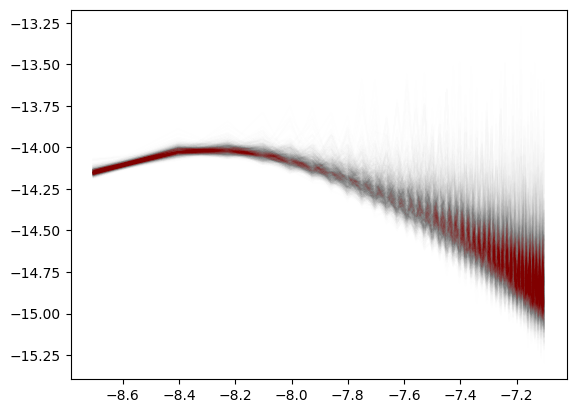

In [30]:
for i in range(nreal):
    plt.plot(np.log10(spectra["fobs"][:]), np.log10(gwb[:, i]), alpha=0.005, color='maroon')

17:45:21 INFO : calculating normalization exactly [hardening.py:__init__]
17:45:21 INFO : calculating normalization exactly [hardening.py:__init__]
17:45:21 INFO : calculating normalization exactly [hardening.py:__init__]
17:45:21 INFO : calculating normalization exactly [hardening.py:__init__]
17:45:21 INFO : calculating normalization exactly [hardening.py:__init__]
17:45:35 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:45:35 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
17:45:35 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:45:35 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
17:45:35 INFO : Adding MMbulge scatter (2.9999e-01) [sam.py:static_binary_density]
17:45:35 INFO : 	dens bef: (1.19e-87, 3.58e-41, 5.13e-13, 6.19e-05, 2.06e-03, 8.90e-03, 4.75e-02) [sam.py:static_binary_density]
17:45:35 INFO : zero_coalesced=T

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:45:45 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:45:45 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:45:45 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]


/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: Runtim

17:45:46 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:45:46 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:45:46 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:45:46 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:45:46 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:45:46 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:45:46 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:45:46 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:45:46 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 

/Users/kayhan/miniconda3/envs/awgbusy202211/lib/python3.9/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child4), but could not find a label for it.
  warnings.warn(


17:46:08 INFO : calculating normalization exactly [hardening.py:__init__]
17:46:08 INFO : calculating normalization exactly [hardening.py:__init__]
17:46:08 INFO : calculating normalization exactly [hardening.py:__init__]
17:46:08 INFO : calculating normalization exactly [hardening.py:__init__]
17:46:08 INFO : calculating normalization exactly [hardening.py:__init__]
17:46:22 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:46:22 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
17:46:22 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:46:22 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
17:46:22 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:46:22 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:46:22 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/sam.py:614: RuntimeWarning: invalid value encountered in divide
  err = (dens - dens_check) / dens_check
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/sam.py:646: RuntimeWarning: invalid value encountered in divide
  err = (dens - dens_check) / dens_check


17:46:28 INFO : Scatter added after 6.450836 sec [sam.py:static_binary_density]
17:46:28 INFO : 	dens aft: (2.42e-14, 1.88e-08, 2.83e-06, 2.86e-04, 4.63e-03, 1.50e-02, 5.20e-02) [sam.py:static_binary_density]
17:46:28 INFO : 	mass: 5.60e-02 ==> 5.89e-02 || change = 5.0045e-02 [sam.py:static_binary_density]
17:46:28 WARNING : NOT zeroing out systems with GMTs extending past redshift zero! [sam.py:static_binary_density]
17:46:28 INFO : Scatter added after 6.559488 sec [sam.py:static_binary_density]
17:46:28 INFO : 	dens aft: (4.48e-30, 4.66e-14, 2.85e-10, 4.44e-05, 1.73e-03, 7.12e-03, 2.52e-02) [sam.py:static_binary_density]
17:46:28 INFO : 	mass: 2.25e-02 ==> 2.38e-02 || change = 5.7545e-02 [sam.py:static_binary_density]
17:46:28 WARNING : NOT zeroing out systems with GMTs extending past redshift zero! [sam.py:static_binary_density]
17:46:28 INFO : Scatter added after 6.573557 sec [sam.py:static_binary_density]
17:46:28 INFO : 	dens aft: (2.49e-24, 5.22e-12, 7.23e-09, 8.28e-05, 2.28e-03

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:46:32 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:46:32 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:46:32 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]


/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: Runtim

17:46:32 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:46:32 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:46:32 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:46:32 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:46:32 WARNING : A large fraction of binaries are stalled at all xvals!  8.73

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/sam.py:614: RuntimeWarning: invalid value encountered in divide
  err = (dens - dens_check) / dens_check
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/sam.py:646: RuntimeWarning: invalid value encountered in divide
  err = (dens - dens_check) / dens_check


17:47:08 INFO : Adding MMbulge scatter (2.9999e-01) [sam.py:static_binary_density]
17:47:08 INFO : 	dens bef: (1.19e-87, 3.58e-41, 5.13e-13, 6.19e-05, 2.06e-03, 8.90e-03, 4.75e-02) [sam.py:static_binary_density]
17:47:14 INFO : Scatter added after 6.483294 sec [sam.py:static_binary_density]
17:47:14 INFO : 	dens aft: (1.69e-25, 1.64e-12, 3.90e-09, 7.24e-05, 2.16e-03, 8.25e-03, 2.91e-02) [sam.py:static_binary_density]
17:47:14 INFO : 	mass: 2.72e-02 ==> 2.87e-02 || change = 5.5369e-02 [sam.py:static_binary_density]
17:47:14 WARNING : NOT zeroing out systems with GMTs extending past redshift zero! [sam.py:static_binary_density]
17:47:14 INFO : Scatter added after 6.534819 sec [sam.py:static_binary_density]
17:47:14 INFO : 	dens aft: (9.14e-16, 7.90e-09, 8.79e-07, 2.18e-04, 3.90e-03, 1.30e-02, 4.51e-02) [sam.py:static_binary_density]
17:47:14 INFO : 	mass: 4.72e-02 ==> 4.96e-02 || change = 5.0953e-02 [sam.py:static_binary_density]
17:47:14 WARNING : NOT zeroing out systems with GMTs exten

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)


17:47:18 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:47:18 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:47:18 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:47:18 WARNING : A large fraction of binaries are stalled at all xvals!  8.73

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:47:18 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:47:18 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:47:18 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:47:18 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 sam

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: Runtim

17:48:03 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:48:03 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:48:03 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:48:03 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:48:03 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:48:03 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:48:03 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:48:03 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:48:03 WARNING : A large fraction of binaries are stalled at all xvals!  8.73

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:48:46 INFO : fraction of stalled binary-xvals: 2.40e+06/2.56e+06 = 9.39e-01 [sam.py:dynamic_binary_number]
17:48:46 INFO : fraction of binaries stalled at all xvals: 6.04e+04/6.40e+04 = 9.43e-01 [sam.py:dynamic_binary_number]
17:48:46 WARNING : A large fraction of binaries are stalled at all xvals!  9.4306e-01 [sam.py:dynamic_binary_number]


/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:48:48 INFO : fraction of stalled binary-xvals: 2.31e+06/2.56e+06 = 9.02e-01 [sam.py:dynamic_binary_number]
17:48:48 INFO : fraction of binaries stalled at all xvals: 5.81e+04/6.40e+04 = 9.08e-01 [sam.py:dynamic_binary_number]
17:48:48 WARNING : A large fraction of binaries are stalled at all xvals!  9.0805e-01 [sam.py:dynamic_binary_number]


/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:48:49 INFO : fraction of stalled binary-xvals: 2.22e+06/2.56e+06 = 8.66e-01 [sam.py:dynamic_binary_number]
17:48:49 INFO : fraction of binaries stalled at all xvals: 5.59e+04/6.40e+04 = 8.74e-01 [sam.py:dynamic_binary_number]
17:48:49 WARNING : A large fraction of binaries are stalled at all xvals!  8.7375e-01 [sam.py:dynamic_binary_number]
17:49:16 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:49:16 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
17:49:16 INFO : Adding MMbulge scatter (2.9999e-01) [sam.py:static_binary_density]
17:49:16 INFO : 	dens bef: (1.19e-87, 3.58e-41, 5.13e-13, 6.19e-05, 2.06e-03, 8.90e-03, 4.75e-02) [sam.py:static_binary_density]
17:49:21 INFO : Scatter added after 5.440227 sec [sam.py:static_binary_density]
17:49:21 INFO : 	dens aft: (7.77e-20, 3.91e-10, 8.43e-08, 1.32e-04, 2.94e-03, 1.04e-02, 3.62e-02) [sam.py:static_binary_density]
17:49:21 INFO : 	mass: 3.60e-02 ==> 3.79

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:49:25 INFO : fraction of stalled binary-xvals: 2.12e+06/2.56e+06 = 8.28e-01 [sam.py:dynamic_binary_number]
17:49:25 INFO : fraction of binaries stalled at all xvals: 5.36e+04/6.40e+04 = 8.38e-01 [sam.py:dynamic_binary_number]
17:49:25 WARNING : A large fraction of binaries are stalled at all xvals!  8.3797e-01 [sam.py:dynamic_binary_number]
17:49:32 INFO : zero_coalesced=True, zero_stalled=True [sam.py:dynamic_binary_number]
17:49:32 INFO : Stalled SAM bins based on GMT: 4.80e+04/6.40e+04 = 7.50e-01 [sam.py:static_binary_density]
17:49:32 INFO : Adding MMbulge scatter (2.9999e-01) [sam.py:static_binary_density]
17:49:32 INFO : 	dens bef: (1.19e-87, 3.58e-41, 5.13e-13, 6.19e-05, 2.06e-03, 8.90e-03, 4.75e-02) [sam.py:static_binary_density]
17:49:38 INFO : Scatter added after 5.450631 sec [sam.py:static_binary_density]
17:49:38 INFO : 	dens aft: (7.77e-20, 3.91e-10, 8.43e-08, 1.32e-04, 2.94e-03, 1.04e-02, 3.62e-02) [sam.py:static_binary_density]
17:49:38 INFO : 	mass: 3.60e-02 ==> 3.79

/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:782: RuntimeWarning: divide by zero encountered in divide
  frac = (xx - xvals[1]) / np.subtract(*xvals)
/Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/holodeck/utils.py:787: RuntimeWarning: invalid value encountered in multiply
  ynew = data[1] + (np.subtract(*data) * frac)


17:49:41 INFO : fraction of stalled binary-xvals: 1.99e+06/2.56e+06 = 7.76e-01 [sam.py:dynamic_binary_number]
17:49:41 INFO : fraction of binaries stalled at all xvals: 5.04e+04/6.40e+04 = 7.88e-01 [sam.py:dynamic_binary_number]
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
Done with SAM
Found 0.00e+00/1.00e+00 = 0.00e+00 samples with NaN entries.  Removing them from library.
Choosing center_measure
17:50:03 INFO : calculating normalization exactly [hardening.py:__init__]
17:50:03 INFO : calculating normalization exactly [harden

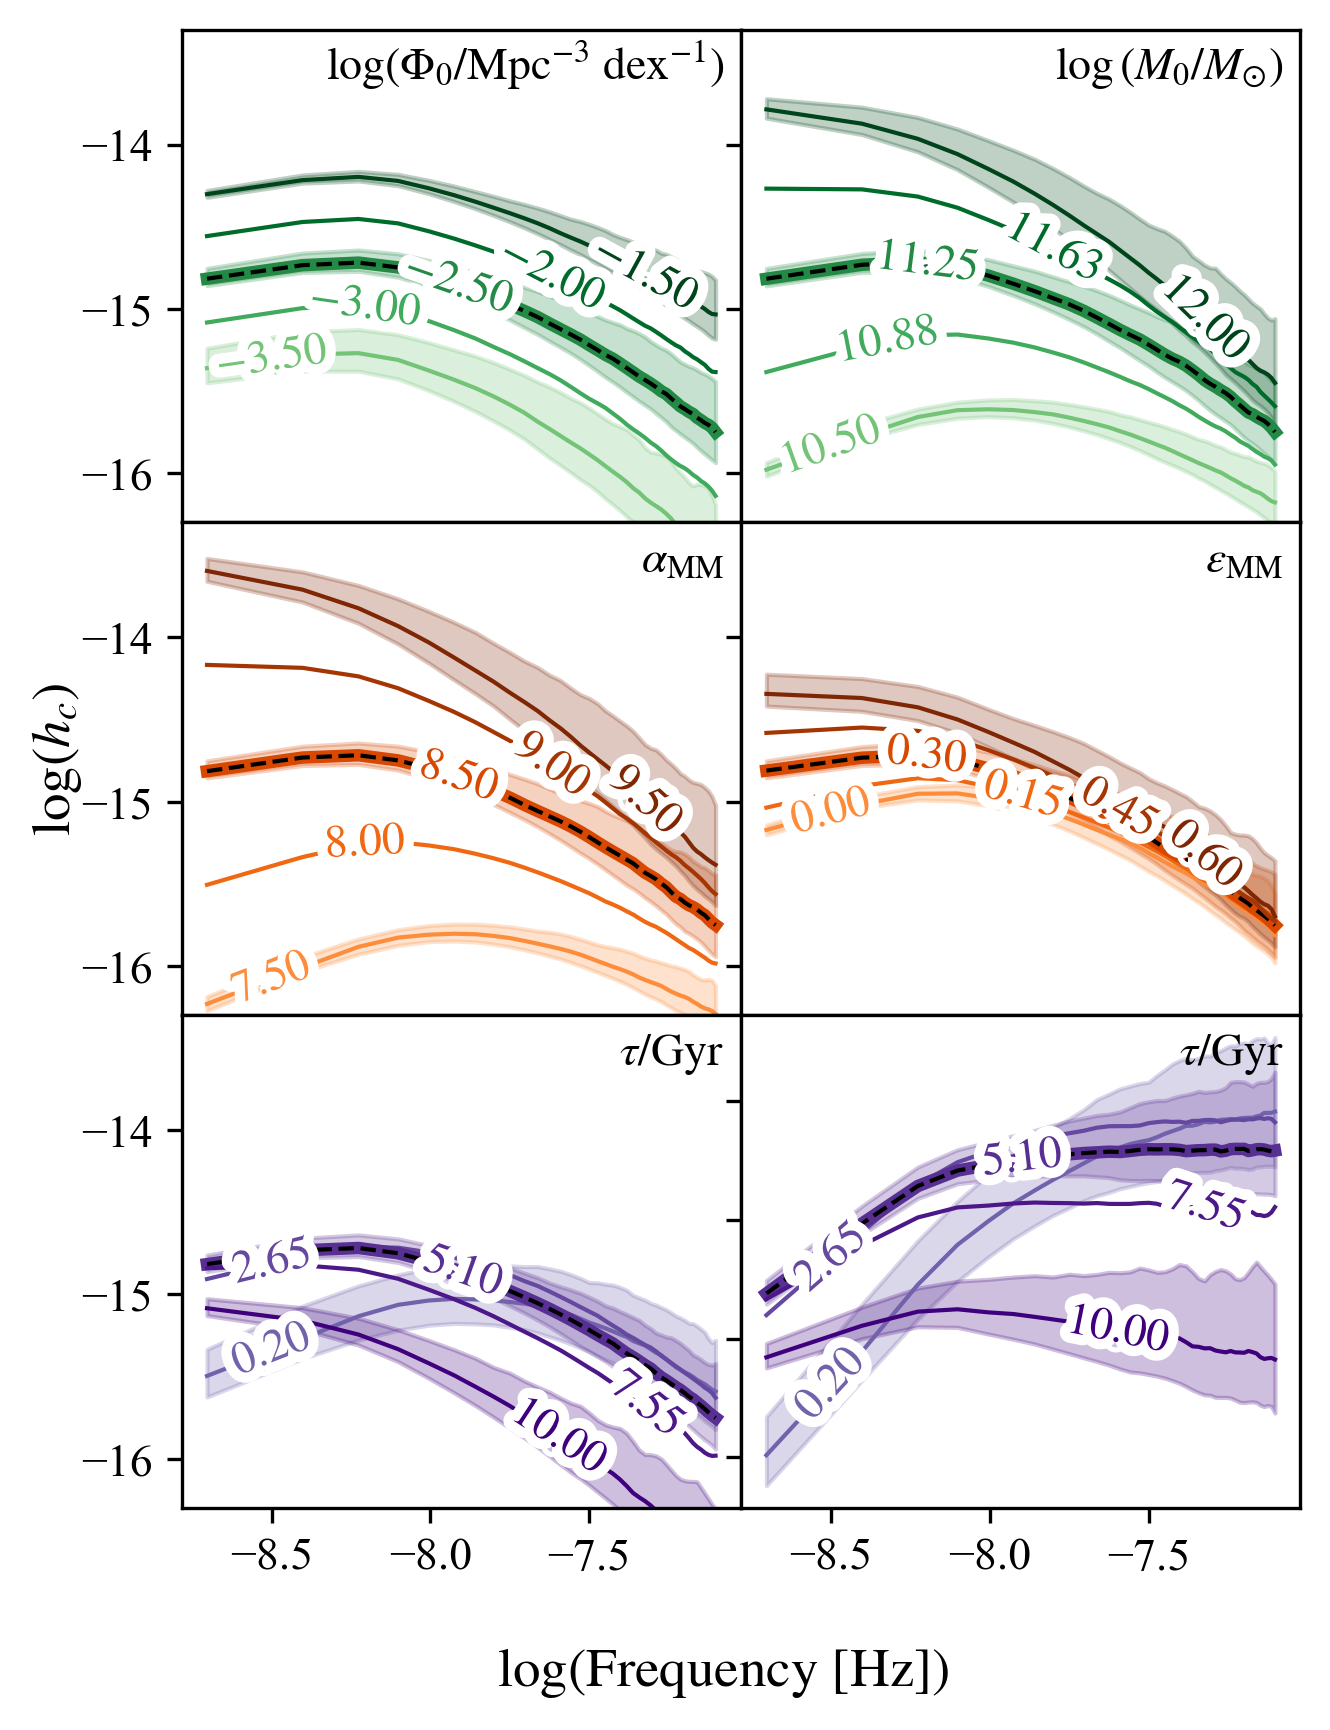

In [51]:

for nreal in [1000]:
    fig, axs = plt.subplots(3,2, sharex='all', figsize=(6.4/1.33, 6.4), dpi=300)
    fig.subplots_adjust(hspace=0, wspace=0)
    fltaxs = axs.flatten()
    for i, par_interest in enumerate([list(pars_linspace.keys())[ii] for ii in [1, 2, 3, 4, 0, 0]]): # ['gsmf_phi0']): # ['hard_time', 'gsmf_phi0']): # 
        plt.sca(fltaxs[i])
        pu.pub_plot_individual_parameter(
            gp_george,
            gp,
            mean_pars,
            par_interest,
            spectra,
            find_sam_mean=True,
            model=sam_model.sam_for_params, # model_for_params, # 
            plot_dir="plots",
            nreal=nreal,
            num_points=5,
            multiprocessing=True,
            ax=fltaxs[i],
            panelnumb=i
        )
    fig.supxlabel('$\log(\mathrm{Frequency\ [Hz]})$')
    fig.supylabel(r"$\log(h_{c})$")
    if fltaxs.size > 5:
        pass #fig.delaxes(fltaxs[5])
    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass
    # label_outer() should be smart enough to know if it is an outer axis and not just on the last row, but it isn't
    if fltaxs.size > 2:
        pass #fltaxs[2].xaxis.set_tick_params(which="major", labelbottom=True)
    fname = f"plots/pub_param_varied_extra_all_{nreal}.pdf"
    fig.savefig(fname)

In [52]:
print(spectra['fobs_edges'][:].shape, spectra['fobs'][:].shape)


(41,) (40,)


In [21]:
print(spectra["fobs"][:])

[1.97679899e-09 3.95359798e-09 5.93039697e-09 7.90719596e-09
 9.88399495e-09 1.18607939e-08 1.38375929e-08 1.58143919e-08
 1.77911909e-08 1.97679899e-08 2.17447889e-08 2.37215879e-08
 2.56983869e-08 2.76751859e-08 2.96519849e-08 3.16287838e-08
 3.36055828e-08 3.55823818e-08 3.75591808e-08 3.95359798e-08
 4.15127788e-08 4.34895778e-08 4.54663768e-08 4.74431758e-08
 4.94199748e-08 5.13967737e-08 5.33735727e-08 5.53503717e-08
 5.73271707e-08 5.93039697e-08 6.12807687e-08 6.32575677e-08
 6.52343667e-08 6.72111657e-08 6.91879647e-08 7.11647636e-08
 7.31415626e-08 7.51183616e-08 7.70951606e-08 7.90719596e-08]


### Getting back numerical values
`plotting_utils.plot_individual_parameter()` can optionally return numerical results

In [71]:
?pu.plot_individual_parameter

### Plotting all parameters
The following cell will plot GWBs for each paramter, shading the regions in between the extrema. Once again, the values held constant are specified by `mean_pars`, but you can supply your own.

Plot saved at /Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/notebooks/plots/params_varied.png


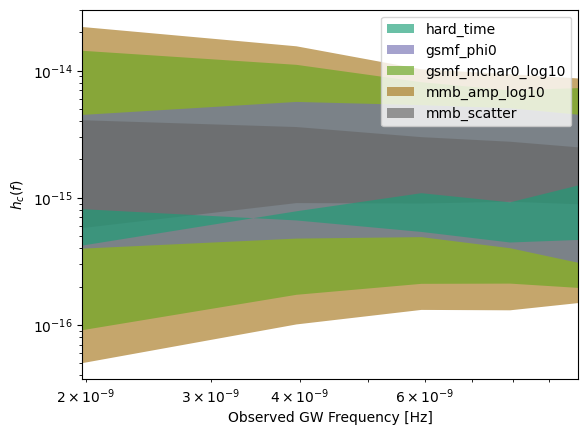

In [106]:
pu.plot_parameter_variances(
    gp_george, gp, mean_pars, spectra, alpha=0.65, plot_dir="plots"
)

### Plotting prediction over the data from the library
In the following cell, you can plot the GP's prediction on top of all of the realizations for a given parameter combination from the training data. If you reserved a training set, this would be a good place to choose an index that lies within the training set.

Found 4.00e+00/4.00e+03 = 1.00e-03 samples with NaN entries.  Removing them from library.
setting aside 0.0 of samples (0) for testing, and choosing 5 frequencies
         filter_window=2 filter_poly_order=1
Plot saved at /Users/kayhan/Documents/projects/nanograv/awgbusy/holodeck/notebooks/gp_overplotted.png
hard_time = 4.24E+00
gsmf_phi0 = -3.07E+00
gsmf_mchar0_log10 = 1.17E+01
mmb_amp_log10 = 7.62E+00
mmb_scatter = 3.92E-01


array([ 4.23900963, -3.07234395, 11.65585289,  7.6193025 ,  0.39188484])

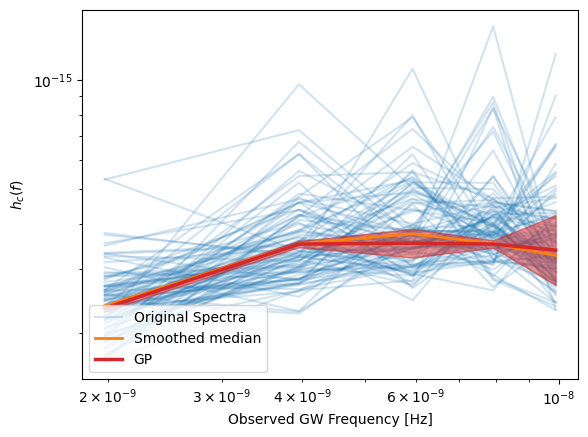

In [107]:
index = 300
pu.plot_over_realizations(index, spectra, gp_george, gp)

### Drawing from the emcee chain
Below, you'll see an example of drawing $h_\rm{c}(f)$ samples from the emcee chain. 

In [108]:
# Parameters from above plot
use_pars = [-4.95E-01, -6.01E-01, 2.13E+00, 1.57E+00, -2.03E+00, 8.48E+00]

# To use mean_pars, see below
#hc = gu.sample_hc_from_gp(gp_george, gp, list(mean_pars.values()), 100)


# I'm using the parameters from above because the spectra for the mean parameters are rather simple
hc = gu.sample_hc_from_gp(gp_george, gp, use_pars, 100)

ValueError: Dimension mismatch

In [ ]:
?gu.sample_hc_from_gp

In [ ]:
freqs = spectra["fobs"][: hc.shape[1]]
for i in range(hc.shape[0]):
    plt.loglog(freqs, hc[i, :], color="#4682b4", alpha=0.3)

plt.xlabel("Observed GW Frequency [Hz]")
plt.ylabel(r"$h_{c} (f)$")